In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [3]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content='There\'s no single "best" place to see orcas in the US, as it depends on the time of year and what kind of orca viewing experience you\'re looking for.  Different locations offer different opportunities.  Here are a few of the top contenders, with considerations for each:\n\n* **Washington State (San Juan Islands):** This is arguably the most popular and reliable location in the US for orca sightings.  The resident Southern Resident orcas (J, K, and L pods) frequent the waters here, and tour operators are abundant and experienced.  However, these orcas are endangered, so responsible whale watching is crucial.  Peak season is generally summer.\n\n* **Alaska:**  Alaska boasts several areas where you can see orcas, but they\'re often transient orcas, meaning they\'re not as consistently found in specific locations.  Areas like Southeast Alaska (Juneau, Ketchikan) and Prince William Sound offer excellent opportunities, often with sightings of larger pods.  The viewing ex

In [7]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': []}

# **Tools**

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools: ChatGoogleGenerativeAI = llm.bind_tools([multiply])

In [9]:
function_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
function_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e3d2572b-3736-4385-856d-e7f574911271-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': 'f5f93ec2-4194-478a-8000-10d01f82b775', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 3, 'total_tokens': 60, 'input_token_details': {'cache_read': 0}})

In [10]:
function_call.additional_kwargs['function_call']

{'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}

# **Using messages as state**

In [12]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

# **Reducer**

When updating the messages state key, new values usually overwrite the old ones. To avoid this and instead append new messages, we can use a reducer function. Reducers define how state updates happen. By using the add_messages reducer, we ensure new messages are added to the existing list rather than replacing it. Just annotate the messages key with the add_messages reducer.

In [13]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

LangGraph provides a pre-built `MessagesState` for handling message lists efficiently.

### Key Features:
- Includes a pre-defined `messages` key.
- The `messages` key is a list of `AnyMessage` objects.
- Automatically uses the `add_messages` reducer to append messages.

Using `MessagesState` is simpler and less verbose compared to creating a custom `TypedDict`.




In [14]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

In [15]:
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]


new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='2fd242c9-c4be-456a-af30-b1c93b0721df'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='c1757e03-2ff8-4662-aaa0-a249c47e14d7'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='ac29bcbe-0b62-4c5f-9ec1-877188de8d78')]

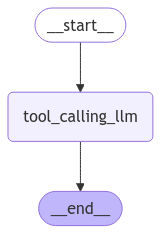

In [16]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph


def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph: CompiledStateGraph  = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you today?


In [18]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 4 and 2!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 4 and 2!
================================== Ai Message ==================================
Tool Calls:
  multiply (61bcfa58-fc17-41c0-891e-4fb18ea8f658)
 Call ID: 61bcfa58-fc17-41c0-891e-4fb18ea8f658
  Args:
    a: 4.0
    b: 2.0
